In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import imghdr
import matplotlib.pyplot as plt

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
print(data_dir)
data_dir = pathlib.Path(data_dir)
data_dir

In [ ]:
# data_dir = pathlib.Path("plant")
# data_dir

# Commented out because this is wrong

In [ ]:
# Clean up the data

In [ ]:
batch_size = 32
img_height = 194
img_width = 256

In [ ]:
# 
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed = 1,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed = 1,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [ ]:
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=6
)

In [6]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
# Limiting GPU memory growth to avoid OOM errors
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Remove Dodgy Images

In [4]:
# Our directory name
data_dir = "plant"

In [5]:
# Image extensions
image_exts=  ["jpeg", "jpg", "bmp", "png"]

Issue with image plant\potato 'King Edward'\.ipynb_checkpoints
Image data of dtype object cannot be converted to float


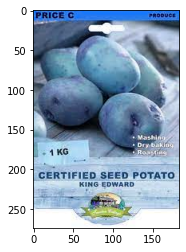

In [6]:
# Going through all the images and removing images that are not right extensions
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        # The full image path
        
        try:
            img = cv2.imread(image_path)
            plt.imshow(img)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Removing image : Wrong extension")
                os.remove(image_path)
        except Exception as e:
            print(f"Issue with image {image_path}")
            print(e)

# Load Data

In [7]:
# Loading Data allows you to create data pipeline allowing you to scale large dataset
data = tf.keras.utils.image_dataset_from_directory('plant')
# Resizes image to 256, 256

Found 292 files belonging to 1 classes.


In [8]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [132]:
# Conver the data into numpy iterator to access the elements
data_iterator = data.as_numpy_iterator()

In [133]:
# Getting a batch
# We passed 1 batch
# Class 0 - potatoes
batch = data_iterator.next()

In [134]:
# Images represented as numpy arrays
batch[0].shape
# Batch size is 32 and image size is 256, 256
# Can also change the batch size
# Can change image size

(32, 256, 256, 3)

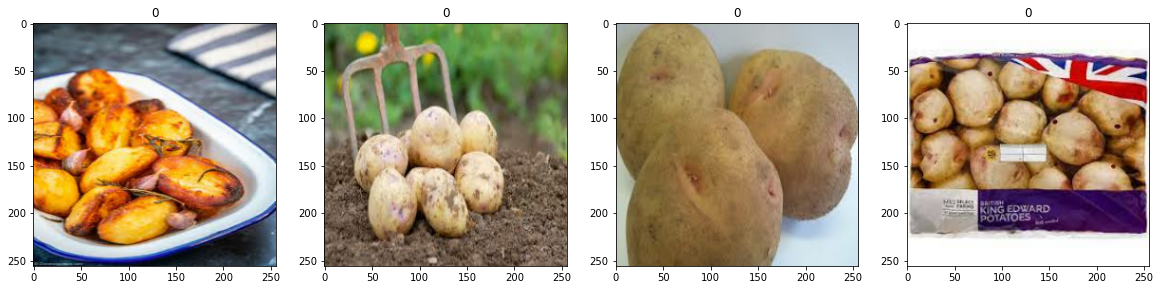

In [135]:
# Here, 0s all mean potatoes
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preprocessing

In [59]:
# We are going to pre-process the images from 0 to 1 instead of 0 to 255
# We are also splitting data into training testing and validation

Scale

In [136]:
# Make sure to reload the data and run this
# If you run this twice, you will dark images because we are
# dividing the rgb values twice
scaled_data = data.map(lambda x,y: (x/255, y))
# Changing 0 to 255 to 0 to 1

In [137]:
# Conver the data into numpy iterator to access the elements
scaled_iterator = scaled_data.as_numpy_iterator()

In [138]:
batch = scaled_iterator.next()

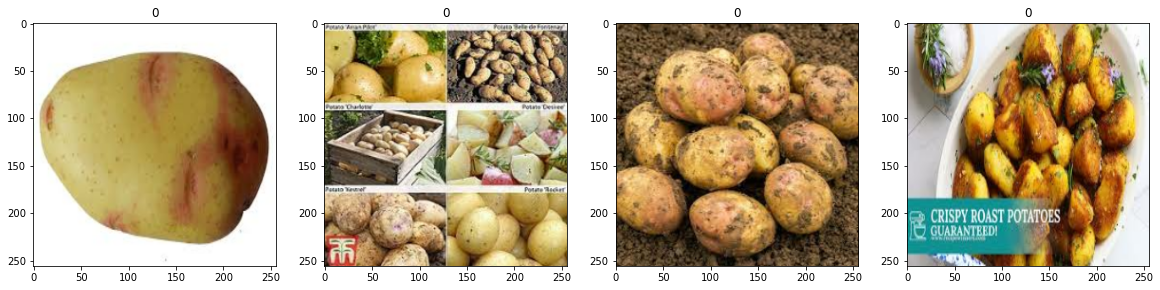

In [139]:
# Here, 0s all mean potatoes
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(float)) # Should be float
    ax[idx].title.set_text(batch[1][idx])

In [140]:
batch[0].max()

1.0

# Split Data

In [141]:
batch_len = len(data)
# We have 9 batches for now

In [142]:
# train size should be 70 percent of the data
train_size = int(batch_len*.7)
# validation size should be 20 percent of the data
val_size = int(batch_len*.2) + 1
# test size should be 10 percent of the data
test_size = int(batch_len * .1) + 1

In [143]:
train_size

6

In [124]:
val_size

2

In [125]:
test_size

1

In [126]:
# Total is 9

In [144]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size) # Skip train and take val
test = data.skip(train_size + val_size).take(test_size)